In [215]:
#!pip install transformers

In [216]:
#!pip install -U sentence-transformers

In [223]:
#!conda install pytorch torchvision -c pytorch

In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sentence_transformers import SentenceTransformer

/opt/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#!pip install packaging --upgrade

In [3]:
df1 = pd.read_csv("data_10000.csv")
df2 = pd.read_csv("data_20000.csv")
df3 = pd.read_csv("data_30000.csv")
#df4 = pd.read_csv("data_40000.csv")
#df5 = pd.read_csv("data_50000.csv")

In [4]:
df = pd.concat([df1, df2, df3], ignore_index=True)
df.head()

,Unnamed: 0,Title,Author,Description,Publisher,Year Published,Genres,Page Count
0,0,The Strange Maid,['Tessa Gratton'],"Fans of Neil Gaiman, Holly Black, and Maggie S...",Random House Books for Young Readers,2014.0,"['Fantasy', 'Young Adult', 'Fantasy', 'Mytholo...",400.0
1,1,A Darker Domain,['Val McDermid'],"1984, Fife. Heiress Catriona Maclennan Grant &...",HarperCollins Publishers,2008.0,"['Mystery', 'Mystery', 'Crime', 'Fiction', 'Cu...",371.0
2,2,A Thousand Naked Strangers: A Paramedic's Wild...,['Kevin Hazzard'],"A former paramedic’s visceral, poignant, and m...",Scribner,2016.0,"['Nonfiction', 'Autobiography', 'Memoir', 'Med...",261.0
3,3,Looking Back with a Smile,['Edward B. Farber'],"In Looking Back with a Smile, the author recol...",NaN,2012.0,[],NaN
4,4,Bargain Paradise,['Darlene Blasing'],Bargain Paradise is a humorous tale of an obse...,Argon Press,2013.0,[],49.0


In [5]:
df.shape

(30000, 8)

In [6]:
df.loc[0]

Unnamed: 0                                                        0
Title                                              The Strange Maid
Author                                            ['Tessa Gratton']
Description       Fans of Neil Gaiman, Holly Black, and Maggie S...
Publisher                      Random House Books for Young Readers
Year Published                                                 2014
Genres            ['Fantasy', 'Young Adult', 'Fantasy', 'Mytholo...
Page Count                                                      400
Name: 0, dtype: object

In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
df["Genres"].apply(lambda x: [i for i in x[1:-1].replace("'", "").split(", ") if len(i) != 0])

0        [Fantasy, Young Adult, Fantasy, Mythology, Fic...
1        [Mystery, Mystery, Crime, Fiction, Cultural, S...
2        [Nonfiction, Autobiography, Memoir, Medical, B...
3                                                       []
4                                                       []
                               ...                        
29995    [Mythology, Mermaids, Fantasy, Young Adult, Ro...
29996    [Nonfiction, Feminism, Politics, Religion, Rel...
29997    [Fiction, Fantasy, Short Stories, Magical Real...
29998    [History, Nonfiction, Military, Military Histo...
29999                                                   []
Name: Genres, Length: 30000, dtype: object

#### The lists were saved as strings

In [9]:
df["Genres"] = df["Genres"].apply(lambda x: [i for i in x[1:-1].replace("'", "").split(", ") if len(i) != 0])

In [10]:
df["Author"]

0                                      ['Tessa Gratton']
1                                       ['Val McDermid']
2                                      ['Kevin Hazzard']
3                                   ['Edward B. Farber']
4                                    ['Darlene Blasing']
                              ...                       
29995                                  ['Sarah  Porter']
29996                                  ['Mona Eltahawy']
29997    ['Haruki Murakami', 'Ted Goossen', 'Chip Kidd']
29998                               ['Robert K. Massie']
29999                                  ['Elijah Powell']
Name: Author, Length: 30000, dtype: object

In [11]:
df["Author"].isna().sum()

2

#### 2 authors is insignificant in comparison to the sample size. Therefore, the rows can safely be dropped

In [12]:
df.dropna(subset=["Author"], axis=0, inplace=True)

In [13]:
df["Author"] = df["Author"].apply(lambda x: x[1:-1].replace("'", "").split(", ") if x is not None else None)

### Missing values

If we are missing genre's information, we would have an empty list instead of NaN. We need to count them as well

In [14]:
df = df[df["Author"].apply(lambda x: True if len(x) != 0 else False)]
df

,Title,Author,Description,Publisher,Year Published,Genres,Page Count
0,The Strange Maid,[Tessa Gratton],"Fans of Neil Gaiman, Holly Black, and Maggie S...",Random House Books for Young Readers,2014.0,"[Fantasy, Young Adult, Fantasy, Mythology, Fic...",400.0
1,A Darker Domain,[Val McDermid],"1984, Fife. Heiress Catriona Maclennan Grant &...",HarperCollins Publishers,2008.0,"[Mystery, Mystery, Crime, Fiction, Cultural, S...",371.0
2,A Thousand Naked Strangers: A Paramedic's Wild...,[Kevin Hazzard],"A former paramedic’s visceral, poignant, and m...",Scribner,2016.0,"[Nonfiction, Autobiography, Memoir, Medical, B...",261.0
3,Looking Back with a Smile,[Edward B. Farber],"In Looking Back with a Smile, the author recol...",NaN,2012.0,[],NaN
4,Bargain Paradise,[Darlene Blasing],Bargain Paradise is a humorous tale of an obse...,Argon Press,2013.0,[],49.0
...,...,...,...,...,...,...,...
29995,The Twice Lost,[Sarah Porter],Mermaids have been sinking ships and drowning ...,Houghton Mifflin Harcourt,2013.0,"[Mythology, Mermaids, Fantasy, Young Adult, Ro...",480.0
29996,Headscarves and Hymens: Why the Middle East Ne...,[Mona Eltahawy],A passionate manifesto decrying misogyny in th...,"Farrar, Straus and Giroux",2015.0,"[Nonfiction, Feminism, Politics, Religion, Rel...",240.0
29997,The Strange Library,"[Haruki Murakami, Ted Goossen, Chip Kidd]",From internationally acclaimed author Haruki M...,Knopf,2001.0,"[Fiction, Fantasy, Short Stories, Magical Real...",96.0
29998,Dreadnought,[Robert K. Massie],"Pulitzer Prize-winning author, Robert K. Massi...",Ballantine Books,1991.0,"[History, Nonfiction, Military, Military Histo...",1040.0


In [15]:
df = df[df["Genres"].apply(lambda x: True if len(x) != 0 else False)]

In [16]:
df

,Title,Author,Description,Publisher,Year Published,Genres,Page Count
0,The Strange Maid,[Tessa Gratton],"Fans of Neil Gaiman, Holly Black, and Maggie S...",Random House Books for Young Readers,2014.0,"[Fantasy, Young Adult, Fantasy, Mythology, Fic...",400.0
1,A Darker Domain,[Val McDermid],"1984, Fife. Heiress Catriona Maclennan Grant &...",HarperCollins Publishers,2008.0,"[Mystery, Mystery, Crime, Fiction, Cultural, S...",371.0
2,A Thousand Naked Strangers: A Paramedic's Wild...,[Kevin Hazzard],"A former paramedic’s visceral, poignant, and m...",Scribner,2016.0,"[Nonfiction, Autobiography, Memoir, Medical, B...",261.0
5,Hester Roon,[Norah Lofts],The Fleece Inn stood where the three roads joi...,Corgi,1940.0,"[Historical, Historical Fiction, Historical, L...",320.0
6,The Trouble with Playing Cupid,[Tamara Philip],"One New Year's Eve, shy singer, December Brown...",Vanilla Heart Publishing,2014.0,"[Romance, Contemporary]",176.0
...,...,...,...,...,...,...,...
29994,The Lonely Hunter: A Biography of Carson McCul...,"[Virginia Spencer Carr, Tennessee Williams]",The Lonely Hunter is widely accepted as the st...,University of Georgia Press,1975.0,"[Biography, Nonfiction, History, Race, Gothic,...",680.0
29995,The Twice Lost,[Sarah Porter],Mermaids have been sinking ships and drowning ...,Houghton Mifflin Harcourt,2013.0,"[Mythology, Mermaids, Fantasy, Young Adult, Ro...",480.0
29996,Headscarves and Hymens: Why the Middle East Ne...,[Mona Eltahawy],A passionate manifesto decrying misogyny in th...,"Farrar, Straus and Giroux",2015.0,"[Nonfiction, Feminism, Politics, Religion, Rel...",240.0
29997,The Strange Library,"[Haruki Murakami, Ted Goossen, Chip Kidd]",From internationally acclaimed author Haruki M...,Knopf,2001.0,"[Fiction, Fantasy, Short Stories, Magical Real...",96.0


In [17]:
df.isna().sum()

Title                0
Author               0
Description        329
Publisher         1423
Year Published      33
Genres               0
Page Count        1126
dtype: int64

### Categorical Data

In [18]:
genres = set()
for l in df["Genres"].values:
    genres = genres.union(set(l))
    
len(genres)

970

In [19]:
genres = {genre: [] for genre in genres}

for book in df.iterrows():
    for genre in genres.keys():
        if(genre in book[1]["Genres"]):
            genres[genre].append(1)
        else:
            genres[genre].append(0)


In [20]:
genres = pd.DataFrame(genres)

In [21]:
genres["Feminism"]

0        0
1        0
2        0
3        0
4        0
        ..
25177    0
25178    0
25179    1
25180    0
25181    0
Name: Feminism, Length: 25182, dtype: int64

In [22]:
genres

,Banned Books,Skepticism,M M M,Asexual,Womens Fiction,Fractured Fairy Tales,Splatterpunk,Humanities,Planets,Theology,...,Southern,Juvenile,Historical Fantasy,Figure Skating,Queer Studies,Japanese History,Students,Anthologies,Biblical Fiction,Faith
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
df.reset_index(inplace=True)

In [24]:
df = pd.concat([df, genres], axis=1)
df

,index,Title,Author,Description,Publisher,Year Published,Genres,Page Count,Banned Books,Skepticism,...,Southern,Juvenile,Historical Fantasy,Figure Skating,Queer Studies,Japanese History,Students,Anthologies,Biblical Fiction,Faith
0,0,The Strange Maid,[Tessa Gratton],"Fans of Neil Gaiman, Holly Black, and Maggie S...",Random House Books for Young Readers,2014.0,"[Fantasy, Young Adult, Fantasy, Mythology, Fic...",400.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,A Darker Domain,[Val McDermid],"1984, Fife. Heiress Catriona Maclennan Grant &...",HarperCollins Publishers,2008.0,"[Mystery, Mystery, Crime, Fiction, Cultural, S...",371.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,A Thousand Naked Strangers: A Paramedic's Wild...,[Kevin Hazzard],"A former paramedic’s visceral, poignant, and m...",Scribner,2016.0,"[Nonfiction, Autobiography, Memoir, Medical, B...",261.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,Hester Roon,[Norah Lofts],The Fleece Inn stood where the three roads joi...,Corgi,1940.0,"[Historical, Historical Fiction, Historical, L...",320.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,The Trouble with Playing Cupid,[Tamara Philip],"One New Year's Eve, shy singer, December Brown...",Vanilla Heart Publishing,2014.0,"[Romance, Contemporary]",176.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25177,29994,The Lonely Hunter: A Biography of Carson McCul...,"[Virginia Spencer Carr, Tennessee Williams]",The Lonely Hunter is widely accepted as the st...,University of Georgia Press,1975.0,"[Biography, Nonfiction, History, Race, Gothic,...",680.0,0,0,...,0,0,0,0,0,0,0,0,0,0
25178,29995,The Twice Lost,[Sarah Porter],Mermaids have been sinking ships and drowning ...,Houghton Mifflin Harcourt,2013.0,"[Mythology, Mermaids, Fantasy, Young Adult, Ro...",480.0,0,0,...,0,0,0,0,0,0,0,0,0,0
25179,29996,Headscarves and Hymens: Why the Middle East Ne...,[Mona Eltahawy],A passionate manifesto decrying misogyny in th...,"Farrar, Straus and Giroux",2015.0,"[Nonfiction, Feminism, Politics, Religion, Rel...",240.0,0,0,...,0,0,0,0,0,0,0,0,0,0
25180,29997,The Strange Library,"[Haruki Murakami, Ted Goossen, Chip Kidd]",From internationally acclaimed author Haruki M...,Knopf,2001.0,"[Fiction, Fantasy, Short Stories, Magical Real...",96.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df.drop(columns=["index"], index=1, inplace=True)
df

,Title,Author,Description,Publisher,Year Published,Genres,Page Count,Banned Books,Skepticism,M M M,...,Southern,Juvenile,Historical Fantasy,Figure Skating,Queer Studies,Japanese History,Students,Anthologies,Biblical Fiction,Faith
0,The Strange Maid,[Tessa Gratton],"Fans of Neil Gaiman, Holly Black, and Maggie S...",Random House Books for Young Readers,2014.0,"[Fantasy, Young Adult, Fantasy, Mythology, Fic...",400.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A Thousand Naked Strangers: A Paramedic's Wild...,[Kevin Hazzard],"A former paramedic’s visceral, poignant, and m...",Scribner,2016.0,"[Nonfiction, Autobiography, Memoir, Medical, B...",261.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Hester Roon,[Norah Lofts],The Fleece Inn stood where the three roads joi...,Corgi,1940.0,"[Historical, Historical Fiction, Historical, L...",320.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,The Trouble with Playing Cupid,[Tamara Philip],"One New Year's Eve, shy singer, December Brown...",Vanilla Heart Publishing,2014.0,"[Romance, Contemporary]",176.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Suicide Watch,[Kelley York],18-year-old Vincent has spent his entire life ...,Kelley York,2012.0,"[Romance, M M Romance, Young Adult, LGBT, Cont...",220.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25177,The Lonely Hunter: A Biography of Carson McCul...,"[Virginia Spencer Carr, Tennessee Williams]",The Lonely Hunter is widely accepted as the st...,University of Georgia Press,1975.0,"[Biography, Nonfiction, History, Race, Gothic,...",680.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25178,The Twice Lost,[Sarah Porter],Mermaids have been sinking ships and drowning ...,Houghton Mifflin Harcourt,2013.0,"[Mythology, Mermaids, Fantasy, Young Adult, Ro...",480.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25179,Headscarves and Hymens: Why the Middle East Ne...,[Mona Eltahawy],A passionate manifesto decrying misogyny in th...,"Farrar, Straus and Giroux",2015.0,"[Nonfiction, Feminism, Politics, Religion, Rel...",240.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25180,The Strange Library,"[Haruki Murakami, Ted Goossen, Chip Kidd]",From internationally acclaimed author Haruki M...,Knopf,2001.0,"[Fiction, Fantasy, Short Stories, Magical Real...",96.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Examine the descriptions

In [26]:
test = [df["Description"].loc[0], df["Description"].loc[2], df["Description"].loc[3]]

In [27]:
test[1]

'A former paramedic’s visceral, poignant, and mordantly funny account of a decade spent on Atlanta’s mean streets saving lives and connecting with the drama and occasional beauty that lies inside catastrophe.In the aftermath of 9/11 Kevin Hazzard felt that something was missing from his life—his days were too safe, too routine. A failed salesman turned local reporter, he wa\nA former paramedic’s visceral, poignant, and mordantly funny account of a decade spent on Atlanta’s mean streets saving lives and connecting with the drama and occasional beauty that lies inside catastrophe.In the aftermath of 9/11 Kevin Hazzard felt that something was missing from his life—his days were too safe, too routine. A failed salesman turned local reporter, he wanted to test himself, see how he might respond to pressure and danger. He signed up for emergency medical training and became, at age twenty-six, a newly minted EMT running calls in the worst sections of Atlanta. His life entered a different realm

#### The first lines are repeated. It is the segment of text that gets displayed at first before the user clicks on "more". In addition, that "\n...more" is displayed at the end of the text. We need to clean this up.

In [28]:
len("Fans of Neil Gaiman, Holly Black, and Maggie Stiefvater will embrace the richly drawn, Norse-influenced alternate world of the United States of Asgard, where cell phones, rock bands, and evangelical preachers coexist with dragon slaying, rune casting, and sword training in schools. Where the president runs the country alongside a council of Valkyries, gods walk the red car\n")

376

In [29]:
len("A former paramedic’s visceral, poignant, and mordantly funny account of a decade spent on Atlanta’s mean streets saving lives and connecting with the drama and occasional beauty that lies inside catastrophe.In the aftermath of 9/11 Kevin Hazzard felt that something was missing from his life—his days were too safe, too routine. A failed salesman turned local reporter, he wa\n")

376

In [30]:
for t in test:
    print(t[376:-8])

Fans of Neil Gaiman, Holly Black, and Maggie Stiefvater will embrace the richly drawn, Norse-influenced alternate world of the United States of Asgard, where cell phones, rock bands, and evangelical preachers coexist with dragon slaying, rune casting, and sword training in schools. Where the president runs the country alongside a council of Valkyries, gods walk the red carpet with Hollywood starlets, and the U.S. military has a special battalion dedicated to eradicating Rocky Mountain trolls. Signy Valborn was seven years old when she climbed the New World Tree and met Odin Alfather, who declared that if she could solve a single riddle, he would make her one of his Valkyrie. For ten years Signy has trained in the arts of war, politics, and leadership, never dreaming that a Greater Mountain Troll might hold the answer to the riddle, but that’s exactly what Ned the Spiritless promises her. A mysterious troll hunter who talks in riddles and ancient poetry, Ned is a hard man to trust. Unfo

#### This will be applied to all the descriptions:

This proof-of-concept is NLP based, therefore I will drop the books that have no description. That is only 1% of the current data set.

In [31]:
df["Description"].isna().sum()/df.shape[0]

0.013065406457249514

In [32]:
df.dropna(subset=["Description"], inplace=True)

### Data Preprocessing

In [74]:
def text_preprocessed(descriptions):
    
    description_processed = descriptions.apply(lambda x: x[376:-8])

    ### Remove anything that is not an alphabetical character, or a space.
    description_processed = description_processed.replace('[^a-zA-Z ]', " ", regex=True)

    ### Case unification
    description_processed = description_processed.apply(lambda x: x.lower())

    ### Stopword removal
    stopword_list = stopwords.words("english")
    description_processed = description_processed.apply(lambda x: [word for word in x.split() if word not in stopword_list])

    ### Bigrams
    phrase_model = Phrases(list(description_processed), min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
    #df["Description_processed"] = [" ".join(phrase_model[sentence]) for sentence in df["Description_processed"]]
    description_processed = [phrase_model[sentence] for sentence in description_processed]

    ### Stemming & Lemmatization
    description_processed = [" ".join([SnowballStemmer("english").stem(WordNetLemmatizer().lemmatize(word)) for word in text]) for text in description_processed]
    
    return description_processed

df["Description_processed"] = text_preprocessed(df["Description"])

### Experiment #1: TF-IDF and Cosine Similarity

In [34]:
tf = TfidfVectorizer(analyzer="word", ngram_range=(1,3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df["Description_processed"])
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cos_sim

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 3.38774632e-04, ...,
        1.22521232e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.38774632e-04, 1.00000000e+00, ...,
        1.33667231e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 1.22521232e-03, 1.33667231e-03, ...,
        1.00000000e+00, 6.49583062e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.49583062e-04, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [36]:
all_books = pd.Series(df["Title"])
all_books[:10]

0                                      The Strange Maid
2     A Thousand Naked Strangers: A Paramedic's Wild...
3                                           Hester Roon
4                        The Trouble with Playing Cupid
5                                         Suicide Watch
6                                       I´ll Walk Alone
7                                   A Pair of Red Clogs
8     More Women of Wonder: Science Fiction Novelett...
9     Father Arseny, 1893-1973: Priest, Prisoner, Sp...
10                                   The Last Sanctuary
Name: Title, dtype: object

In [37]:
all_books.iloc[600]

'Charlie and the Great Glass Elevator'

In [38]:
def get_recommendations(book, cos_sim=cos_sim):
    idx = all_books[all_books == book].index[0] #index of the book at question
    scores = pd.Series(cos_sim[idx]).sort_values(ascending=False)
    #The highest is going to be the book itself, so we exclude it
    top_10_idx = scores.iloc[1:11].index
    return scores[1:11], all_books.loc[top_10_idx]

In [39]:
df[df["Title"].str.contains("Harry Potter")]

,Title,Author,Description,Publisher,Year Published,Genres,Page Count,Banned Books,Skepticism,M M M,...,Juvenile,Historical Fantasy,Figure Skating,Queer Studies,Japanese History,Students,Anthologies,Biblical Fiction,Faith,Description_processed
3540,Harry Potter and the Methods of Rationality,[Eliezer Yudkowsky],Harry Potter and the Methods of Rationality is...,hpmor.com & fanfiction.net,2015.0,"[Fantasy, Fiction, Fan Fiction, Philosophy, Sc...",2184.0,0,0,0,...,0,0,0,0,0,0,0,0,0,harry_pott method ration work alternate_univer...
4037,Harry Potter and the Deathly Hallows,[J.K. Rowling],"It's no longer safe for Harry at Hogwarts, so ...",Arthur A. Levine Books,2007.0,"[Fantasy, Young Adult, Fiction, Fantasy, Magic...",759.0,0,0,0,...,0,0,0,0,0,0,0,0,0,longer_saf harri hogwarts_best friend ron herm...
12620,Harry Potter and the Sorcerer's Stone,[J.K. Rowling],Harry Potter's life is miserable. His parents ...,Scholastic Inc,1997.0,"[Fantasy, Fiction, Young Adult, Fantasy, Magic...",309.0,0,0,0,...,0,0,0,0,0,0,0,0,0,harry_pott life_miser parents_dead stuck heart...
21001,Harry Potter: A History of Magic,"[British Library, J.K. Rowling, Julian Harriso...",Harry Potter: A History of Magic is the offici...,Bloomsbury,2017.0,"[Fantasy, Fiction, Audiobook, Young Adult, Fan...",256.0,0,0,0,...,0,0,0,0,0,0,0,0,0,harry_pott history_mag official_book exhibit l...
22468,"Harry, a History: The True Story of a Boy Wiza...","[Melissa Anelli, J.K. Rowling]",THE HARRY POTTER BOOKS WERE JUST THE BEGINNING...,Gallery Books,2008.0,"[Nonfiction, Autobiography, Memoir, Biography,...",356.0,0,0,0,...,0,0,0,0,0,0,0,0,0,harry_pott book begin stori brief span_on deca...


In [40]:
scores, recommendations = get_recommendations('Harry Potter and the Deathly Hallows')

In [41]:
recommendations

23806                              Stories Of The Prophets
20101                                       The Iron Lance
22243                                          Mr. Psychic
6703     The Man Who Ate His Boots: The Tragic History ...
6283                          The Loneliest Vampire in NYC
22139                                              Forever
24850                                           Futureland
22715                                  'Til the World Ends
19822    Zero to One: Notes on Startups, or How to Buil...
7055                                             Possessed
Name: Title, dtype: object

In [194]:
scores

23806    0.020658
20101    0.016718
22243    0.016594
6703     0.016182
6283     0.013223
22139    0.012986
24850    0.012597
22715    0.012443
19822    0.012252
7055     0.012045
dtype: float64

### Experiment #2: TF-IDF and Clustering

##### Reducing dimensions so that it is plottable

In [161]:
### Initially tried PCA. However, it does not work for sparse inputs.
#pca = PCA(2)
#df = pca.fit_transform(tfidf_matrix)
#svd = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
#svd_data = svd.fit_transform(tfidf_matrix)

In [195]:
svd_data = tfidf_matrix

In [196]:
kmeans = KMeans(n_clusters= 10)
label = kmeans.fit_predict(svd_data)

In [197]:
label

array([4, 9, 2, ..., 9, 6, 0], dtype=int32)

ValueError: setting an array element with a sequence.

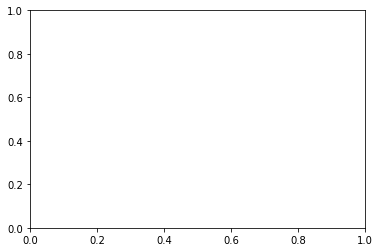

In [169]:
#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(svd_data[label == i , 0] , svd_data[label == i , 1] , label = i)
plt.legend()
plt.show()

### Experiment #3: Sentence Transofmrers/BERT and Clustering

In [62]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = list(df["Description_processed"])

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


In [63]:
books_embeddings = list(zip(df["Title"], df["Description"], embeddings))

In [64]:
cos_sim_embeddings = cosine_similarity(embeddings,embeddings)

In [66]:
scores, recommendations = get_recommendations('Harry Potter and the Deathly Hallows', cos_sim_embeddings)

In [67]:
scores

19670    0.788545
16027    0.770192
1896     0.763471
20293    0.763228
11736    0.763059
9089     0.762973
2401     0.760832
9913     0.758609
12702    0.758377
21936    0.755704
dtype: float32

In [68]:
recommendations

19670                                           Waterbound
16027                               Keturah and Lord Death
1896     The Ignorant Maestro: How Great Leaders Inspir...
20293                                    Emily of New Moon
11736                                             Headlong
9089                                 The End of the Matter
2401                                      Kidnapped Hearts
9913     The Most Interesting Person in the Room: A bri...
12702                        The Greeks and the Irrational
21936                                             Corbenic
Name: Title, dtype: object

The cosine similarity scores here are quite high. However, I looked at the book description for a few of these, and I don't see how they are similar to Harry Potter. In addition, some of them were a bit too vague. Therefore, I decided to try again with a different dataset that has the book SUMMARIES instead of the descriptions of Goodreads. 

In [71]:
df2 = pd.read_csv("booksummaries.txt", sep='\t', names=["Wikipedia ID", "Freebase ID", "Book title", "Book author", "Publication date", "Genres", "Plot Summary"])

In [75]:
df2.head()

,Wikipedia ID,Freebase ID,Book title,Book author,Publication date,Genres,Plot Summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [82]:
df2.shape

(16559, 8)

In [77]:
df2["Summary_processed"] = text_preprocessed(df2["Plot Summary"])

In [79]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = list(df2["Summary_processed"])

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

In [83]:
books_embeddings = list(zip(df2["Book title"], embeddings))

In [84]:
cos_sim_embeddings = cosine_similarity(embeddings,embeddings)

In [85]:
all_books = pd.Series(df2["Book title"])
all_books[:10]

0                                  Animal Farm
1                           A Clockwork Orange
2                                   The Plague
3    An Enquiry Concerning Human Understanding
4                         A Fire Upon the Deep
5               All Quiet on the Western Front
6                         A Wizard of Earthsea
7                           Anyone Can Whistle
8              Blade Runner 3: Replicant Night
9            Blade Runner 2: The Edge of Human
Name: Book title, dtype: object

In [86]:
scores, recommendations = get_recommendations("Harry Potter and the Philosopher's Stone", cos_sim_embeddings)

In [87]:
scores

480      0.799137
948      0.755065
12207    0.750974
15186    0.749860
445      0.747034
716      0.737015
724      0.734902
7677     0.731284
13090    0.717387
4841     0.716605
dtype: float32

### Experiment #4: Restricted Boltzmann Machine